In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set seaborn style with default colors
sns.set_style("whitegrid")
sns.set_palette("deep")  # Default seaborn palette

In [14]:
# Load the tuning results
df = pd.read_csv('../data_saving/tuning_iter_400.csv')
df.head()

,lambda,gamma,max_iters,adam,schedule,acc_mean,acc_std,prec_mean,prec_std,rec_mean,rec_std,f1_mean,f1_std,optimal_threshold
0,0.000000,1.0,400,1,nagfree,0.874341,0.000975,0.361573,0.002056,0.552407,0.006272,0.437046,0.002079,0.735148
1,0.000000,1.0,400,1,nagfree,0.874835,0.000979,0.362515,0.002128,0.550267,0.006086,0.437061,0.002078,0.736595
2,0.000001,1.0,400,1,nagfree,0.873875,0.000834,0.360729,0.001828,0.554651,0.005561,0.437134,0.002012,0.734962
3,0.000010,1.0,400,1,nagfree,0.874122,0.000724,0.361170,0.001610,0.553477,0.005165,0.437095,0.001899,0.738959
4,0.000100,1.0,400,1,nagfree,0.878294,0.000866,0.369540,0.002380,0.535703,0.005644,0.437357,0.002619,0.761851


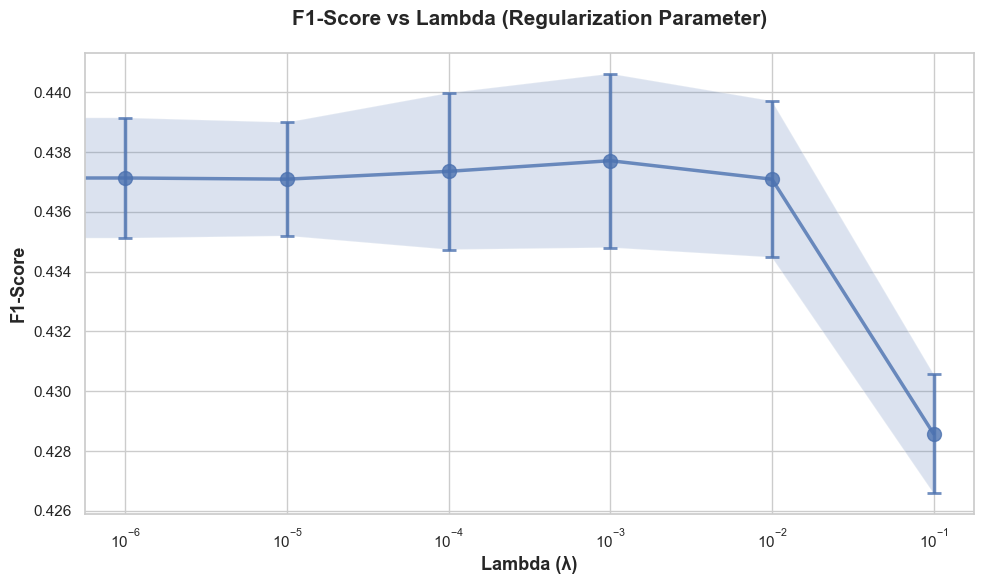

In [15]:
# Plot F1-score vs lambda with seaborn styling
fig, ax = plt.subplots(figsize=(10, 6))

# Plot with error bars using default colors
ax.errorbar(df['lambda'], df['f1_mean'], yerr=df['f1_std'], 
            marker='o', capsize=5, capthick=2, linewidth=2.5, markersize=10,
            alpha=0.8)

# Fill between for shaded error region
ax.fill_between(df['lambda'], 
                df['f1_mean'] - df['f1_std'], 
                df['f1_mean'] + df['f1_std'], 
                alpha=0.2)

ax.set_xscale('log')
ax.set_xlabel('Lambda (λ)', fontsize=13, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=13, fontweight='bold')
ax.set_title('F1-Score vs Lambda (Regularization Parameter)', fontsize=15, fontweight='bold', pad=20)
ax.tick_params(labelsize=11)

plt.tight_layout()
plt.show()

# Plot 2

In [23]:
# Add parent directory to path to import modules
import sys
sys.path.append('..')
import config
import metrics
import implementations
import cv_utils  # Import cv_utils to use find_optimal_threshold

In [24]:
# Find the best hyperparameter configuration
best_config = df.loc[df['f1_mean'].idxmax()]

print(f"Best Model Configuration:")
print(f"  Lambda: {best_config['lambda']:.0e}")
print(f"  Gamma: {best_config['gamma']:.0e}")
print(f"  Max Iters: {int(best_config['max_iters'])}")
print(f"  Optimal Threshold: {best_config['optimal_threshold']:.4f}")
print(f"  F1 Score: {best_config['f1_mean']:.4f} ± {best_config['f1_std']:.4f}")

Best Model Configuration:
  Lambda: 1e-03
  Gamma: 1e+00
  Max Iters: 400
  Optimal Threshold: 0.7828
  F1 Score: 0.4377 ± 0.0029


In [25]:
# Load preprocessed data
import os
preproc_path = os.path.join('..', config.PREPROC_DATA_PATH)
preproc_data = np.load(preproc_path)
X_train = preproc_data['X_train']
y_train = preproc_data['y_train']

print(f"\nTraining model with best hyperparameters...")

# Train the best model
lambda_ = best_config['lambda']
gamma = best_config['gamma']
max_iters = int(best_config['max_iters'])

initial_w = np.zeros(X_train.shape[1])
weights, loss = implementations.reg_logistic_regression(
    y_train, X_train, lambda_, initial_w, max_iters, gamma
)

print("Model training complete!")


Training model with best hyperparameters...
Model training complete!


In [27]:
# Get predicted probabilities
y_prob = implementations.sigmoid(X_train @ weights)

# Find the TRUE optimal threshold using the sophisticated algorithm
true_optimal_threshold, precision_opt, recall_opt, f1_opt = cv_utils.find_optimal_threshold(y_train, y_prob)

print(f"True optimal threshold: {true_optimal_threshold:.4f}")
print(f"F1 at optimal threshold: {f1_opt:.4f}")

# Also compute F1 scores across a range of thresholds for visualization
thresholds = np.linspace(0, 1, 101)  # 101 points from 0 to 1
f1_scores = []

for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    precision, recall, f1 = metrics.precision_recall_f1(y_train, y_pred)
    f1_scores.append(f1)

print(f"F1 Score Range: [{min(f1_scores):.4f}, {max(f1_scores):.4f}]")

True optimal threshold: 0.3895
F1 at optimal threshold: 0.4309
F1 Score Range: [0.0000, 0.4307]


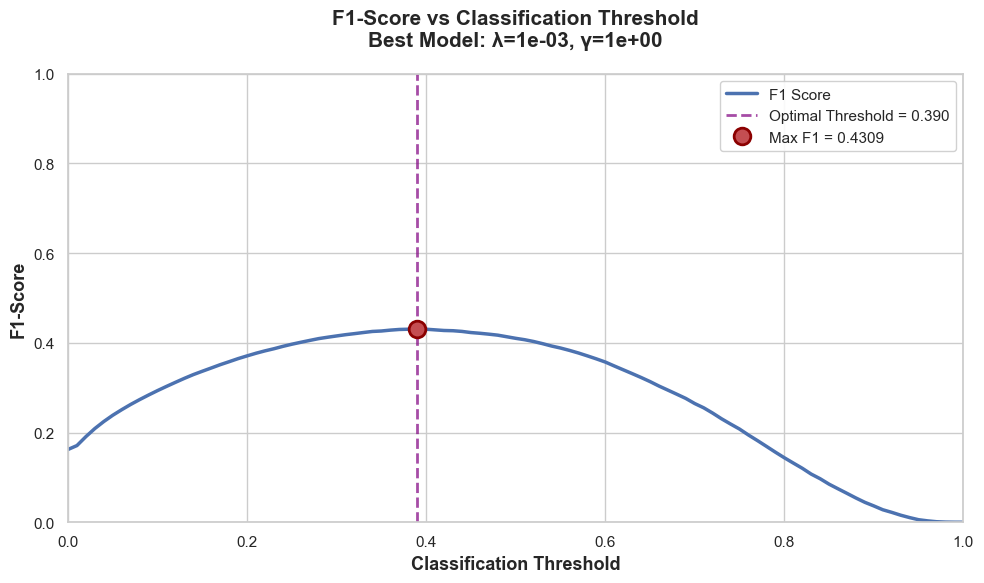

In [28]:
# Plot F1-score vs Threshold
fig, ax = plt.subplots(figsize=(10, 6))

# Plot F1 score
ax.plot(thresholds, f1_scores, linewidth=2.5, label='F1 Score')

# Use the TRUE optimal threshold from find_optimal_threshold function
max_f1_threshold = true_optimal_threshold
max_f1 = f1_opt

# Mark the optimal threshold
ax.axvline(max_f1_threshold, color='purple', linestyle='--', linewidth=2, 
           label=f'Optimal Threshold = {max_f1_threshold:.3f}', alpha=0.7)
ax.plot(max_f1_threshold, max_f1, 'ro', markersize=12, 
        markeredgecolor='darkred', markeredgewidth=2,
        label=f'Max F1 = {max_f1:.4f}', zorder=5)

# Formatting
ax.set_xlabel('Classification Threshold', fontsize=13, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=13, fontweight='bold')
ax.set_title(f'F1-Score vs Classification Threshold\nBest Model: λ={lambda_:.0e}, γ={gamma:.0e}', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best', framealpha=0.9)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.tick_params(labelsize=11)

plt.tight_layout()
plt.show()

In [ ]:
# Compare the thresholds
print(f"Optimal threshold from CSV (CV): {best_config['optimal_threshold']:.4f}")
print(f"Optimal threshold on full train set (using find_optimal_threshold): {true_optimal_threshold:.4f}")
print(f"Difference: {abs(true_optimal_threshold - best_config['optimal_threshold']):.4f}")
print(f"\nThis difference is normal because:")
print(f"  - CSV threshold was computed during cross-validation (averaged across folds)")
print(f"  - Current threshold is computed on the full training set")
print(f"  - Different data splits lead to different optimal thresholds")

Optimal threshold from CSV (CV): 0.7828
Optimal threshold on full train set: 0.3900
Difference: 0.3928

This difference is normal because:
  - CSV threshold was computed during cross-validation (averaged across folds)
  - Current threshold is computed on the full training set
  - Different data splits lead to different optimal thresholds


# plot 3

In [ ]:
# Train all 6 models and evaluate them
best_lambda = best_config['lambda']
best_gamma = best_config['gamma']

print("Training all 6 models...")
print(f"Using lambda={best_lambda:.2e}, gamma={best_gamma:.2e}, max_iters={config.FINAL_MAX_ITERS}\n")

results = {}

# 1. Mean Squared Error - Gradient Descent
print("1/6 Training: MSE with Gradient Descent...")
initial_w = np.zeros(X_train.shape[1])
w_mse_gd, _ = implementations.mean_squared_error_gd(y_train, X_train, initial_w, config.FINAL_MAX_ITERS, best_gamma)
y_pred_raw_mse_gd = X_train @ w_mse_gd
threshold_mse_gd, _, _, _ = cv_utils.find_optimal_threshold(y_train, y_pred_raw_mse_gd)
y_pred_mse_gd = (y_pred_raw_mse_gd >= threshold_mse_gd).astype(int)
acc_mse_gd = metrics.accuracy_score(y_train, y_pred_mse_gd)
prec, rec, f1_mse_gd = metrics.precision_recall_f1(y_train, y_pred_mse_gd)
results['MSE-GD'] = {'accuracy': acc_mse_gd, 'f1': f1_mse_gd, 'threshold': threshold_mse_gd}
print(f"   Threshold: {threshold_mse_gd:.4f}, Accuracy: {acc_mse_gd:.4f}, F1: {f1_mse_gd:.4f}")

# 2. Mean Squared Error - SGD
print("2/6 Training: MSE with SGD...")
initial_w = np.zeros(X_train.shape[1])
w_mse_sgd, _ = implementations.mean_squared_error_sgd(y_train, X_train, initial_w, config.FINAL_MAX_ITERS, best_gamma)
y_pred_raw_mse_sgd = X_train @ w_mse_sgd
threshold_mse_sgd, _, _, _ = cv_utils.find_optimal_threshold(y_train, y_pred_raw_mse_sgd)
y_pred_mse_sgd = (y_pred_raw_mse_sgd >= threshold_mse_sgd).astype(int)
acc_mse_sgd = metrics.accuracy_score(y_train, y_pred_mse_sgd)
prec, rec, f1_mse_sgd = metrics.precision_recall_f1(y_train, y_pred_mse_sgd)
results['MSE-SGD'] = {'accuracy': acc_mse_sgd, 'f1': f1_mse_sgd, 'threshold': threshold_mse_sgd}
print(f"   Threshold: {threshold_mse_sgd:.4f}, Accuracy: {acc_mse_sgd:.4f}, F1: {f1_mse_sgd:.4f}")

# 3. Least Squares
print("3/6 Training: Least Squares...")
w_ls, _ = implementations.least_squares(y_train, X_train)
y_pred_raw_ls = X_train @ w_ls
threshold_ls, _, _, _ = cv_utils.find_optimal_threshold(y_train, y_pred_raw_ls)
y_pred_ls = (y_pred_raw_ls >= threshold_ls).astype(int)
acc_ls = metrics.accuracy_score(y_train, y_pred_ls)
prec, rec, f1_ls = metrics.precision_recall_f1(y_train, y_pred_ls)
results['Least Squares'] = {'accuracy': acc_ls, 'f1': f1_ls, 'threshold': threshold_ls}
print(f"   Threshold: {threshold_ls:.4f}, Accuracy: {acc_ls:.4f}, F1: {f1_ls:.4f}")

# 4. Ridge Regression
print("4/6 Training: Ridge Regression...")
w_ridge, _ = implementations.ridge_regression(y_train, X_train, best_lambda)
y_pred_raw_ridge = X_train @ w_ridge
threshold_ridge, _, _, _ = cv_utils.find_optimal_threshold(y_train, y_pred_raw_ridge)
y_pred_ridge = (y_pred_raw_ridge >= threshold_ridge).astype(int)
acc_ridge = metrics.accuracy_score(y_train, y_pred_ridge)
prec, rec, f1_ridge = metrics.precision_recall_f1(y_train, y_pred_ridge)
results['Ridge'] = {'accuracy': acc_ridge, 'f1': f1_ridge, 'threshold': threshold_ridge}
print(f"   Threshold: {threshold_ridge:.4f}, Accuracy: {acc_ridge:.4f}, F1: {f1_ridge:.4f}")

# 5. Logistic Regression (unregularized)
print("5/6 Training: Logistic Regression...")
initial_w = np.zeros(X_train.shape[1])
w_logreg, _ = implementations.logistic_regression(y_train, X_train, initial_w, config.FINAL_MAX_ITERS, best_gamma)
y_prob_logreg = implementations.sigmoid(X_train @ w_logreg)
threshold_logreg, _, _, _ = cv_utils.find_optimal_threshold(y_train, y_prob_logreg)
y_pred_logreg = (y_prob_logreg >= threshold_logreg).astype(int)
acc_logreg = metrics.accuracy_score(y_train, y_pred_logreg)
prec, rec, f1_logreg = metrics.precision_recall_f1(y_train, y_pred_logreg)
results['Logistic Reg'] = {'accuracy': acc_logreg, 'f1': f1_logreg, 'threshold': threshold_logreg}
print(f"   Threshold: {threshold_logreg:.4f}, Accuracy: {acc_logreg:.4f}, F1: {f1_logreg:.4f}")

# 6. Regularized Logistic Regression
print("6/6 Training: Regularized Logistic Regression...")
initial_w = np.zeros(X_train.shape[1])
w_reg_logreg, _ = implementations.reg_logistic_regression(y_train, X_train, best_lambda, initial_w, config.FINAL_MAX_ITERS, best_gamma)
y_prob_reg_logreg = implementations.sigmoid(X_train @ w_reg_logreg)
threshold_reg_logreg, _, _, _ = cv_utils.find_optimal_threshold(y_train, y_prob_reg_logreg)
y_pred_reg_logreg = (y_prob_reg_logreg >= threshold_reg_logreg).astype(int)
acc_reg_logreg = metrics.accuracy_score(y_train, y_pred_reg_logreg)
prec, rec, f1_reg_logreg = metrics.precision_recall_f1(y_train, y_pred_reg_logreg)
results['Reg Logistic Reg'] = {'accuracy': acc_reg_logreg, 'f1': f1_reg_logreg, 'threshold': threshold_reg_logreg}
print(f"   Threshold: {threshold_reg_logreg:.4f}, Accuracy: {acc_reg_logreg:.4f}, F1: {f1_reg_logreg:.4f}")

print("\nAll models trained!")

Training all 6 models...
Using lambda=1.00e-03, gamma=1.00e+00, max_iters=600
Using threshold=0.3895 for classification

1/6 Training: MSE with Gradient Descent...


/Users/badralmahouri/Documents/uni/EPFL/Master/ML/CS-433-ML-Course-Projects/Project 1/notebook/../implementations.py:425: RuntimeWarning: overflow encountered in dot
  grad = -(tx.T.dot(err)) / len(y)
/Users/badralmahouri/Documents/uni/EPFL/Master/ML/CS-433-ML-Course-Projects/Project 1/notebook/../implementations.py:421: RuntimeWarning: invalid value encountered in dot
  err = y - tx.dot(w)


   Accuracy: 0.9117, F1: 0.0000
2/6 Training: MSE with SGD...


/Users/badralmahouri/Documents/uni/EPFL/Master/ML/CS-433-ML-Course-Projects/Project 1/notebook/../implementations.py:423: RuntimeWarning: overflow encountered in dot
  grad = -(tx.T.dot(err))
/Users/badralmahouri/Documents/uni/EPFL/Master/ML/CS-433-ML-Course-Projects/Project 1/notebook/../implementations.py:421: RuntimeWarning: overflow encountered in dot
  err = y - tx.dot(w)


   Accuracy: 0.9117, F1: 0.0000
3/6 Training: Least Squares...
   Accuracy: 0.9143, F1: 0.2466
4/6 Training: Ridge Regression...
   Accuracy: 0.9143, F1: 0.2466
4/6 Training: Ridge Regression...
   Accuracy: 0.9142, F1: 0.2453
5/6 Training: Logistic Regression...
   Accuracy: 0.9142, F1: 0.2453
5/6 Training: Logistic Regression...
   Accuracy: 0.8708, F1: 0.4301
6/6 Training: Regularized Logistic Regression...
   Accuracy: 0.8708, F1: 0.4301
6/6 Training: Regularized Logistic Regression...
   Accuracy: 0.8700, F1: 0.4307

All models trained!
   Accuracy: 0.8700, F1: 0.4307

All models trained!


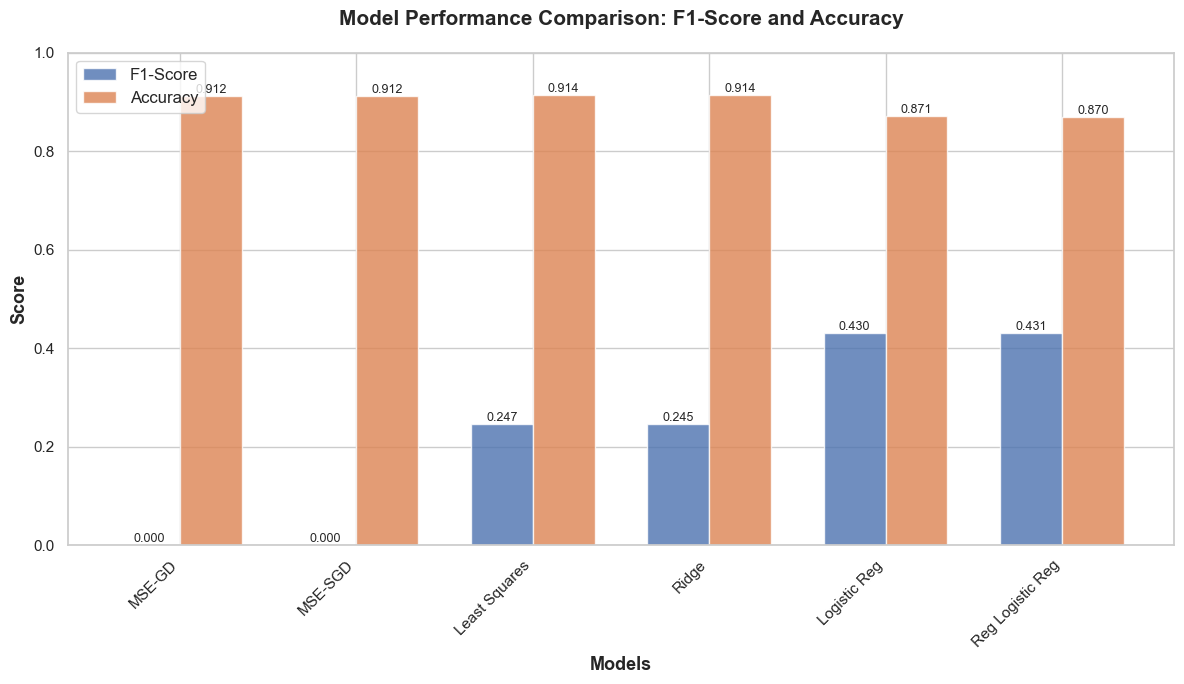

In [30]:
# Create grouped bar plot
model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]
f1_scores = [results[m]['f1'] for m in model_names]

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(model_names))  # Label locations
width = 0.35  # Width of bars

# Create bars
bars1 = ax.bar(x - width/2, f1_scores, width, label='F1-Score', alpha=0.8)
bars2 = ax.bar(x + width/2, accuracies, width, label='Accuracy', alpha=0.8)

# Formatting
ax.set_xlabel('Models', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Model Performance Comparison: F1-Score and Accuracy', fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylim([0, 1])
ax.legend(fontsize=12, loc='upper left')
ax.tick_params(labelsize=11)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [31]:
# Print detailed results to see exact values
print("Detailed Results:")
print("-" * 60)
print(f"{'Model':<20} {'Accuracy':>12} {'F1-Score':>12}")
print("-" * 60)
for model_name in results.keys():
    acc = results[model_name]['accuracy']
    f1 = results[model_name]['f1']
    print(f"{model_name:<20} {acc:>12.4f} {f1:>12.4f}")
print("-" * 60)

Detailed Results:
------------------------------------------------------------
Model                    Accuracy     F1-Score
------------------------------------------------------------
MSE-GD                     0.9117       0.0000
MSE-SGD                    0.9117       0.0000
Least Squares              0.9143       0.2466
Ridge                      0.9142       0.2453
Logistic Reg               0.8708       0.4301
Reg Logistic Reg           0.8700       0.4307
------------------------------------------------------------
